# This notebook:
### Classifies each drifter point into ENSO state

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.colors as mcolors
plt.rcParams.update({'font.size': 18})

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelsize'] = 22

In [3]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

## Let's look at ENSO state oscillations:
##### from https://psl.noaa.gov/enso/mei/

Text(0.5, 1.0, 'ENSO Index by year')

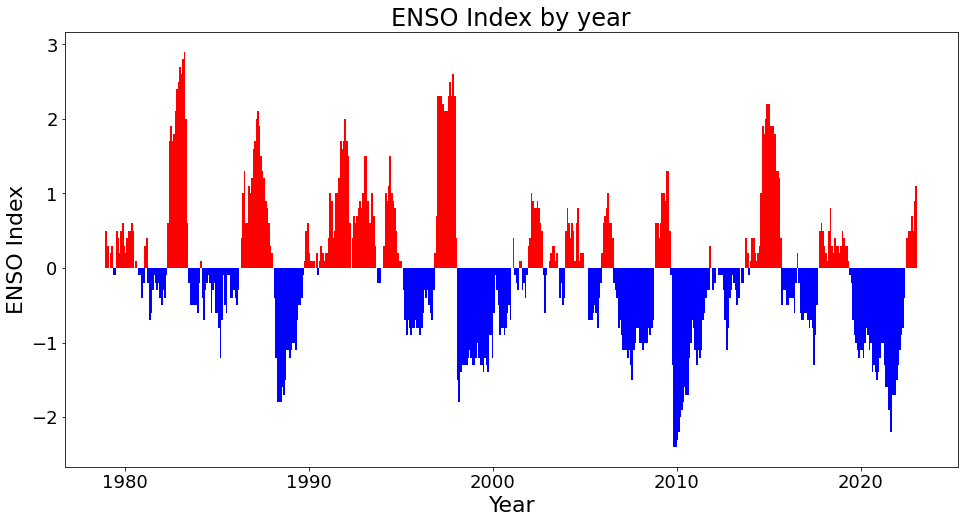

In [4]:
enso_states = pd.read_excel('enso_states.xlsx') # access excel file
enso_states_reshaped = (enso_states.iloc[:, 1:].values).reshape(-1) # reshape index values into array

enso_time_reshaped = (enso_states.iloc[:, 0].values) # reshape time values into array
enso_time_decimal_year = np.linspace(enso_time_reshaped[0], enso_time_reshaped[-1], len(enso_states_reshaped)) # range of decimal years


colors = ['red' if val > 0 else 'blue' for val in enso_states_reshaped] # assign colors
# Plot the values
plt.figure(figsize=(16, 8))
plt.bar(enso_time_decimal_year, enso_states_reshaped, color=colors, width = 0.1)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('ENSO Index')
plt.title('ENSO Index by year')

## Now, let's split the data into either El Nino or La Nina

In [5]:
# separate ENSO years into el nino and la nina based on ENSO index value and save in seconds since 1970
el_nino_years = [enso_time_decimal_year[index] for index, val in enumerate(enso_states_reshaped) if val >= 0]
la_nina_years = [enso_time_decimal_year[index] for index, val in enumerate(enso_states_reshaped) if val < 0]

# convert years into seconds since 1970
seconds_per_year = 60 * 60 * 24 * 365 
la_nina_seconds = [(year - 1970) * seconds_per_year for year in la_nina_years]
el_nino_seconds = [(year -1970) * seconds_per_year for year in el_nino_years]

(1078531200.0, 1261857600.0)

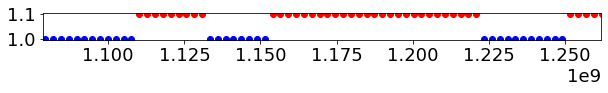

In [195]:
plt.figure(figsize=(10, 0.5))
for year in el_nino_seconds:
    plt.scatter(year, 1, color = 'b')
    
for year in la_nina_seconds:
    plt.scatter(year, 1.1, color = 'r')
plt.xlim((1078531200 , (1261857600 )))

In [66]:
# to assign whether a given chunk in time is el nino or la nina, we divide the min difference between two times by two and add/subtract 
# it to each timestamp value so as to make that timestamp value the 'middle' of the range. This let's us have a set
# of time ranges of equal length either assigned as la nina or el nino, then we can break up each timestamp of actual 
# drifter data into el nino or la nina based on that set of time ranges

In [67]:
#half_time_range = (la_nina_seconds[5] - el_nino_seconds[4]) / 2 # get half_time_range
min_diff_el_nino = min(el_nino_seconds[i+1] - el_nino_seconds[i] for i in range(len(el_nino_seconds)-1))
min_diff_la_nina = min(la_nina_seconds[i+1] - la_nina_seconds[i] for i in range(len(la_nina_seconds)-1))

# Use the minimum difference to calculate the half_time_range
half_time_range = min(min_diff_el_nino, min_diff_la_nina) / 2

# calculate time ranges
la_nina_time_range = [(timestamp - half_time_range, timestamp + half_time_range) for timestamp in la_nina_seconds]
el_nino_time_range = [(timestamp - half_time_range, timestamp + half_time_range) for timestamp in el_nino_seconds]

In [206]:
# let's classify each individual drifter timestamp as existing in el nino or la nina

In [212]:
# get all el nino and la nina times
# beach
el_nino_times_beach = np.logical_or.reduce([(start <= beach['time']) & (beach['time'] <= end) for start, end in el_nino_time_range])
la_nina_times_beach = np.logical_or.reduce([(start <= beach['time']) & (beach['time'] <= end) for start, end in la_nina_time_range])

# unbeach
el_nino_times_unbeach = np.logical_or.reduce([(start <= unbeach['time']) & (unbeach['time'] <= end) for start, end in el_nino_time_range])
la_nina_times_unbeach = np.logical_or.reduce([(start <= unbeach['time']) & (unbeach['time'] <= end) for start, end in la_nina_time_range])

# add ENSO classification to beach dataframe
beach['ENSO'] = np.where(la_nina_times_beach, 'la nina', np.where(el_nino_times_beach, 'el nino', 'none'))
unbeach['ENSO'] = np.where(la_nina_times_unbeach, 'la nina', np.where(el_nino_times_unbeach, 'el nino', 'none'))

In [217]:
# let's save this to a csv:
beach.to_csv('ENSO_beach.csv', index=False) # save to csv
unbeach.to_csv('ENSO_unbeach.csv', index=False) # save to csv